# Introduction to multi-task deep neural network for single-cell multi-omics data (scMultiNet)

In this introductory tutorial, we present the different tasks of a **scMultiNet** workflow

- 1. Loading the multi-omics data
- 2. Training the scMultiNet model
- 3. Integration into the common latent space
- 4. Prediction from modality 1 to modality 2
- 5. Denoising for multi-modality data

import the necessary packages

In [1]:
%matplotlib inline
import os
import torch
import random
import warnings
import numpy as np
import scanpy as sc
import anndata as ad

from MultiNet.trainer import Trainer
from MultiNet.dataloader import SingleCellMultiOmicsData
from MultiNet.multinet import MultiNet
from MultiNet.preprocess import setup_seed
from MultiNet.eval_tools import clustering_metric
from MultiNet.configs import *
warnings.filterwarnings("ignore")

**seed**: Sets the random seed for reproducibility.  
**device**: Specifies the hardware device used for computation (e.g., cpu, cuda).

In [2]:
setup_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step1: Loading data

loading the **BMNC** dataset.  
- **configs**: Configuration information of scMultiNet (hyperparameters, network settings, data preprocessing, etc.)

In [3]:
configs = citeseq_config
configs['use_indicator'] = False  # Set it to True when performing denoising tasks.
Dataname = 'BMNC'
data_path = None

In [4]:
data = SingleCellMultiOmicsData(Dataname, configs, data_path)

Chosen offset: 0.13
==> Successfully preprocessed 2000 genes and 30672 cells.
==> Successfully preprocessed 25 proteins/peaks and 30672 cells.


## Step2: train your scMultiNet model
You can either train the scMultiNet model yourself or load the weights we provide.

In [5]:
multinet = MultiNet(data.n_vars_list, configs)
multinet = multinet.to(device)

In [6]:
train = True
save = True
weight_path = 'BMNC.pth.tar'
if train:
    trainer = Trainer(data, multinet, device)
    trainer.train(configs)
else:
    multinet.load_weight(weight_path)  

if save:
    multinet.save_weight(weight_path)

Pretrain...


Epoch 100/100 g_Loss:0.665433 d_Loss:0.002773 : 100%|█████████████| 100/100 [03:27<00:00,  2.08s/it]


==> Pretrain Done
Train...


Epoch 200/200 g_Loss:0.440291 d_Loss:0.002786 : 100%|█████████████| 200/200 [12:06<00:00,  3.63s/it]

==> Train Done
==> saving checkpoint 'BMNC.pth.tar'


## Step3: Task of Multi-Modality Integration
**Integrate** multi-omic data and use **UMAP** to visualize the clustering results

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
figsize = (3, 3)
n_neighbors=20
min_dist=0.5

In [8]:
x = data.get_one_epoch_data(device)
Y =  data.get_celltypes()
class_num = len(np.unique(Y))
kmeans = KMeans(n_init=20, n_clusters=class_num, random_state=42)
print(class_num)

27


In [9]:
com = multinet.ae_network.get_common_latent_representation(x)

<Figure size 216x216 with 0 Axes>

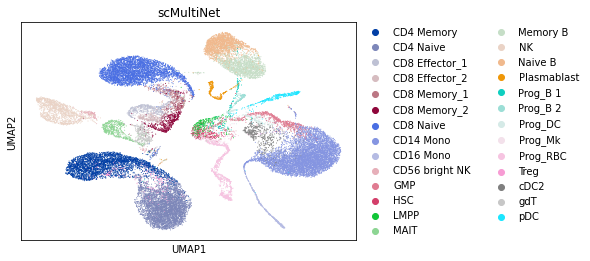

In [10]:
adata = ad.AnnData(X=com)
adata.obs['cell_types'] = Y.astype(str)
sc.pp.pca(adata, n_comps=60)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep="X_pca")
sc.tl.umap(adata, min_dist=min_dist)
plt.figure(figsize=figsize)
sc.pl.umap(adata, color=['cell_types'], title="scMultiNet")

In [11]:
y_pred = kmeans.fit_predict(adata.obsm['X_pca'])
NMI, ARI = clustering_metric(Y, y_pred)
print('NMI: {:.4f}, ARI: {:.4f}'.format(NMI, ARI))

NMI: 0.8384, ARI: 0.8728


## Step4: Task of Cross-Modality Prediction  
Demo: Prediction from **RNA** to **ADT**  
In this demo, we used the complete BMNC dataset for both testing and training, so the results may differ from those reported in the paper.

In [12]:
raw_adt = x[1].cpu().detach().numpy()
corss_adt = multinet.ae_network.get_cross_modality_RNA2ADT(x[0])
# raw_rna = x[0].cpu().detach().numpy
# cross_rna multinet.ae_network.get_cross_modality_ADT2RNA(x[1])

In [13]:
ncols = 2
nrows = 1
figsize = 4
wspace = 0.5

adata_raw = ad.AnnData(X=raw_adt)
adata_cross = ad.AnnData(X=corss_adt)
adata_raw.obs['cell_types'] = Y.astype(str)
adata_cross.obs['cell_types'] = Y.astype(str)
sc.pp.neighbors(adata_raw, n_neighbors=n_neighbors, use_rep="X")
sc.pp.neighbors(adata_cross, n_neighbors=n_neighbors, use_rep="X")
sc.tl.umap(adata_raw, min_dist=min_dist)
sc.tl.umap(adata_cross, min_dist=min_dist)

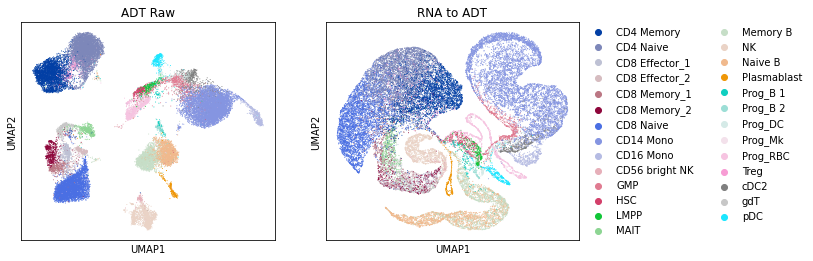

In [14]:
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
sc.pl.umap(adata_raw, color=['cell_types'], title="ADT Raw", ax=axs[0], show=False)
axs[0].get_legend().remove() 
sc.pl.umap(adata_cross, color=['cell_types'], title="RNA to ADT", ax=axs[1])

In [15]:
y_pred = kmeans.fit_predict(adata_raw.X)
NMI1, ARI1 = clustering_metric(Y, y_pred)
y_pred = kmeans.fit_predict(adata_cross.X)
NMI2, ARI2 = clustering_metric(Y, y_pred)
print('Raw  : NMI: {:.4f}, ARI: {:.4f}'.format(NMI1, ARI1))
print('Cross: NMI: {:.4f}, ARI: {:.4f}'.format(NMI2, ARI2))

Raw  : NMI: 0.7516, ARI: 0.5333
Cross: NMI: 0.6738, ARI: 0.5118


## Step5: Task of Multi-Modality Data Denoisiong
Perform this task only when training with indicator matrices and test it using data with artificial dropout.

In [16]:
# rna_denoised, adt_denoised = multinet.ae_network.get_denoised_output(X)